# Speech processing for acoustic features extraction
### Tutors: [Trung Ngo Trong](trung@imito.ai)

-----

# Preparing libraries and data

### Loading neccesary libraries

In [9]:
%matplotlib inline
from __future__ import print_function, absolute_import, division
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
figsize(12, 4)

import os
import sys

import numpy as np
import scipy as sp
import scipy.signal
import scipy.fftpack as fft
from scipy.io import wavfile

from utils import plot_spectrogram, framing

## Load raw signal (.wav file)

We shorten the process here, check * logistic_regression.ipynb * if you don't understand anything, or send an email to our instructors

Sample rate: 8000


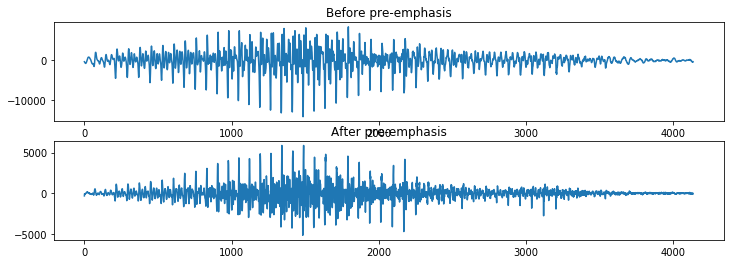

In [2]:
data_path = os.path.join('data', 'sample1.wav')
sample_rate, data = wavfile.read(data_path)
print("Sample rate:", sample_rate)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(data)
plt.title("Before pre-emphasis")
# preemphasis
data = np.append(data[0], data[1:] - 0.97 * data[:-1])
plt.subplot(2, 1, 2)
plt.plot(data)
plt.title("After pre-emphasis")
plt.show()

Step - by - step processing the raw signal
![alt text](img/speech_processing.png "Title")

## Transform signal into time-frequency domain (STFT)

Speech signal has many frequency contents and all of these contents change continuously over time. As a result, pro - cessing the whole audio files would introduce uncontrollable noise and result in unstable spectrogram representation of speech.

* We divide the signal into small enough frames that speech can be characterized in the spectral information, typically, 10 - 25 millisec - onds.
* We also want to minimize the information leakage during partition process, hence, we only shift 5 - 10 milliseconds between successive frames.

In [3]:
WIN_LENGTH = int(0.02 * sample_rate)
HOP_LENGTH = int(0.01 * sample_rate)
MAX_MEM_BLOCK = 2**8 * 2**11 # in bytes
print("Maximum memory block:", MAX_MEM_BLOCK / 1024 / 1024, "MB")
N_FFT = 256
WINDOW = 'hann'
# Divide signal into frame
y_frames = framing(data, frame_length=WIN_LENGTH, hop_length=HOP_LENGTH)
print("#Frames:", y_frames.shape[1])
print("Frame length:", y_frames.shape[0])

Maximum memory block: 0.5 MB
#Frames: 50
Frame length: 160


### Getting the energy of the signal

Log energy can be used for speech activity detection later.

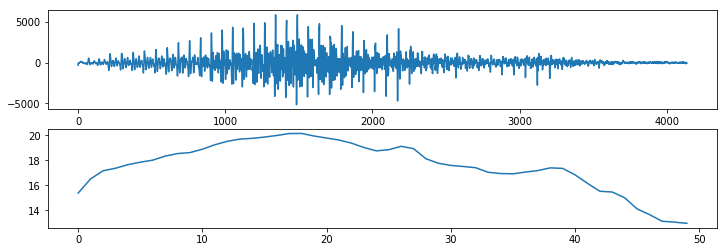

In [4]:
energy = (y_frames**2).sum(axis=0).astype('float32')
energy = np.where(energy == 0., np.finfo(float).eps, energy)
log_energy = np.log(energy).astype('float32')
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(data)
plt.subplot(2, 1, 2)
plt.plot(log_energy)
plt.show()

### Getting the window

Simply cut the files into multiple chunks can cause its spectrum segments develop non - zero values at irrelevant frequencies.
Window function is a mathematical function that is zero - valued outside of some chosen interval.
The STFT is applied to the product of the waveform and a window function.
Window function used is preventing spectral leakage.

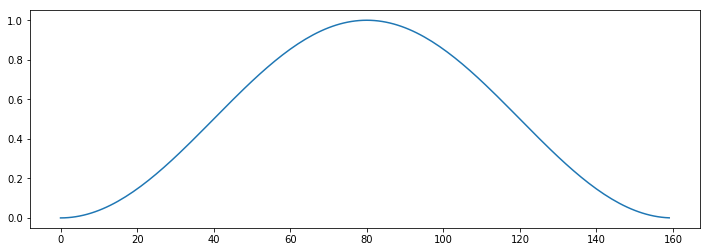

In [5]:
fft_window = scipy.signal.get_window(WINDOW, WIN_LENGTH, fftbins=True
        ).reshape(-1, 1)
plt.figure()
plt.plot(fft_window)

### Processing the STFT

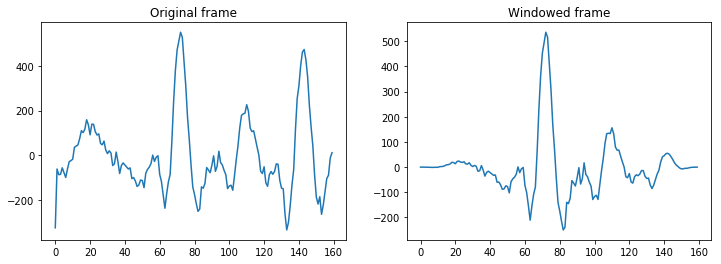

In [6]:
# Pre-allocate the STFT matrix
stft_matrix = np.empty((int(1 + N_FFT // 2), y_frames.shape[1]),
                       dtype=np.complex64,
                       order='F')
# how many columns can we fit within MAX_MEM_BLOCK?
n_columns = int(MAX_MEM_BLOCK / (stft_matrix.shape[0] *
                                 stft_matrix.itemsize))
for bl_s in range(0, stft_matrix.shape[1], n_columns):
    bl_t = min(bl_s + n_columns, stft_matrix.shape[1])
    # RFFT and Conjugate here to match phase from DPWE code
    stft_matrix[:, bl_s:bl_t] = fft.fft(
        fft_window * y_frames[:, bl_s:bl_t],
        n=N_FFT,
        axis=0)[:stft_matrix.shape[0]].conj()

windowed = fft_window * y_frames[:, bl_s:bl_t]
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(y_frames[:, 0])
plt.title("Original frame")
plt.subplot(1, 2, 2)
plt.plot(windowed[:, 0])
plt.title("Windowed frame")
plt.show()

Human is less sensitive to the phase information, so we mostly use log - power spectrum in practice.

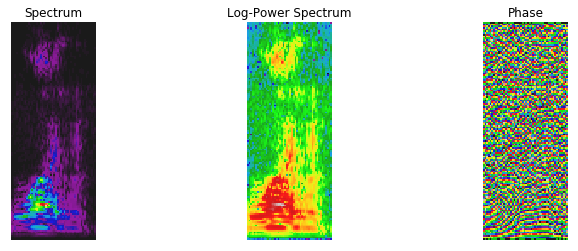

In [8]:
# Magnitude of the STFT
S = np.abs(stft_matrix)
# power spectrum of the STFT
S = S ** 2
# log-power spectrum
logS = np.log10(S)

# getting phase information
P = np.angle(stft_matrix)

# show the log-power spectrum
plt.figure()
plt.subplot(1, 3, 1)
plot_spectrogram(np.abs(stft_matrix))
plt.title("Spectrum")
plt.subplot(1, 3, 2)
plot_spectrogram(logS)
plt.title("Log-Power Spectrum")
plt.subplot(1, 3, 3)
plot_spectrogram(P)
plt.title("Phase")
plt.show()